# 0.0 Imports

In [161]:
import pickle
import optuna
import inflection
import numpy as np
import pandas as pd
import seaborn as sns
import scikitplot as skplt
from IPython.display import Image
from xgboost import XGBClassifier
from sklearn import ensemble as en
from sklearn import neighbors as nh
from lightgbm import LGBMClassifier
from matplotlib import pyplot as plt
from IPython.core.display import HTML
from sklearn import linear_model as lm
from catboost import CatBoostClassifier
from sklearn import preprocessing as pp
from sklearn import model_selection as ms
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import  accuracy_score, balanced_accuracy_score, roc_auc_score, top_k_accuracy_score, roc_curve,auc

# 0.1 Helper Functions

In [162]:
def numerical_metrics(num_attributes):
    #ct = central tendency
    ct_mean = pd.DataFrame(num_attributes.apply(np.mean)).T
    ct_median = pd.DataFrame(num_attributes.apply(np.median)).T

    #d = dispersion
    d_std = pd.DataFrame(num_attributes.apply(np.std)).T
    d_min = pd.DataFrame(num_attributes.apply(min)).T
    d_max = pd.DataFrame(num_attributes.apply(max)).T
    d_range = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
    d_skew = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
    d_kurtosis = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

    #concat
    num_desc = pd.concat([d_min,d_max,d_range,ct_mean,ct_median,d_std,d_skew,d_kurtosis]).T.reset_index()
    num_desc.columns=['attributes','min','max','range','mean','median','std','skew','kurtosis']

    return num_desc

def graphic_percentage(ax,total):
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x() + p.get_width()/2.,height,'{:1.2f}%'.format(height/total*100),ha='center',weight='bold')


def precision_at_k( data, k=20000 ):
    
    data = data.reset_index( drop=True )
    
    #ranking order
    data['ranking'] = data.index + 1
    
    data['precision_at_k'] = data['response'].cumsum() / data['ranking']
    
    return data.loc[ k, 'precision_at_k']

def recall_at_k( data, k=20000 ):
    data = data.reset_index( drop=True )
    data['ranking'] = data.index + 1
    
    data['recall_at_k'] = (data['response'].cumsum() / data['response'].sum() )
    
    return data.loc[ k, 'recall_at_k']

 

def cross_validation(model,x_train,y_train,k, verbose=True):
    
    kfold = StratifiedKFold(n_splits=k,shuffle=True,random_state=42)
    
    accuracy_balanced_list = []
    precision_k_list = [] 
    recall_k_list = []  
    auc_roc_list = []
    top_k_list = []
    i = 1
    
    for train_cv, val_cv in kfold.split(x_train,y_train):
        
        if verbose == True:    
            print(f'Fold Number {i}/{k}') 
        else:
            pass
        
        x_train_fold = x_train.iloc[train_cv]
        y_train_fold = y_train.iloc[train_cv]
        
        x_val_fold = x_train.iloc[val_cv]
        y_val_fold = y_train.iloc[val_cv]
        
        model.fit(x_train_fold,y_train_fold)
        
        yhat_model = model.predict(x_val_fold)
        yhat_proba = model.predict_proba(x_val_fold)

        # Create data to make the precision and recall k and sorted by score
        data = pd.DataFrame()
        
        data = x_val_fold.copy()
        data['response'] = y_val_fold.copy()
        data['score'] = yhat_proba[:,1].tolist()
        data = data.sort_values('score',ascending=False)
        
        knum = y_val_fold.value_counts().count()-1

        # Balanced Accuracy
        accuracy_balanced = balanced_accuracy_score(y_val_fold,yhat_model)
        accuracy_balanced_list.append(accuracy_balanced)
        
        # ROC AUC SCORE
        auc_roc = roc_auc_score(y_val_fold, yhat_proba[:, 1])
        auc_roc_list.append(auc_roc)
        
        # TOP K SCORE
        top_k = top_k_accuracy_score(y_val_fold,yhat_model,k=knum)
        top_k_list.append(top_k)
             
        # Precision at K
        precision_k = precision_at_k(data,20000)
        precision_k_list.append(precision_k)
        
        # Recall at K
        recall_k = recall_at_k(data,20000)
        recall_k_list.append(recall_k)
        i = i + 1
        
    df = pd.DataFrame({'Model Name': type(model).__name__ + ' ' + 'CV',
                       'Model Accuracy': np.round( np.mean(accuracy_balanced_list), 3 ).astype( str ) + '+/-' + np.round( np.std( accuracy_balanced_list), 3).astype( str ),
                       'Precision @K Mean': np.round( np.mean(precision_k_list), 3).astype( str ) + '+/-' + np.round( np.std( precision_k_list), 3).astype( str ),
                       'Recall @K Mean': np.round( np.mean(recall_k_list), 3).astype( str ) + '+/-' + np.round( np.std( recall_k_list), 3).astype( str ),
                       'ROC AUC Score': np.round( np.mean(auc_roc_list), 3).astype( str ) + '+/-' + np.round( np.std( auc_roc_list), 3).astype( str ),
                       'Top @K Mean': np.round( np.mean(top_k_list), 3).astype( str ) + '+/-' + np.round( np.std( top_k_list), 3).astype( str )  },index = [0])
    return df    


In [163]:
 # Metrics @ k
def metrics_at_k(model, x_train, y_train, x_val, y_val, k=20000, sort=True, verbose=False):
    
    # model training
    model.fit(x_train, y_train)

    # model prediction
    yhat_model = model.predict(x_val)
    yhat_proba = model.predict_proba(x_val)

    # copy data
    data = x_val.copy()
    data['response'] = y_val.copy()

    # propensity score
    data['score'] = yhat_proba[:, 1].tolist()

    # sort clients by propensity score
    data = data.sort_values('score', ascending=False)

    knum = y_val.value_counts().count()-1

    acc_score = accuracy_score( y_val, yhat_model )
    precision = precision_at_k(data)
    recall = recall_at_k(data)
    roc_auc = roc_auc_score(y_val,yhat_proba[:, 1])
    top_k = top_k_accuracy_score(y_val, yhat_model,k=knum)
    

    df = pd.DataFrame({'Model_Name': type(model).__name__, 
                       'Model Accuracy': acc_score,
                       'Precision @K': precision,
                       'Recall @K': recall,
                       'ROC AUC Score': roc_auc,
                       'Top K Score': top_k }, index=[0])

  
    return df

In [164]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [20, 10]
    plt.rcParams['font.size'] = 20
    display(HTML( '<style>.container { width:100% !important; }</style>'))
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    sns.set()

In [165]:
jupyter_settings()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


c:\Users\Codo\anaconda3\envs\env1\lib\site-packages\IPython\core\magics\pylab.py:162: UserWarning:

pylab import has clobbered these variables: ['f']
`%matplotlib` prevents importing * from pylab and numpy



## 0.2 Loading Dataset

In [166]:
path = 'C:\\Users\\Codo\Desktop\\repos\\PA_health_insurance\\data\\train.csv'
df_raw = pd.read_csv(path)

In [167]:
df_test = pd.read_csv( 'C:\\Users\\Codo\Desktop\\repos\\PA_health_insurance\\data\\test.csv')

# 1.0 Data Description

In [168]:
df1 = df_raw.copy()

In [169]:
cols_old = ['id', 'Gender', 'Age', 'Driving_License', 'Region_Code',
            'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage', 'Annual_Premium',
            'Policy_Sales_Channel', 'Vintage', 'Response']

# Rename columns
snakecase = lambda x: inflection.underscore(x)
cols_new = list(map(snakecase, cols_old))
df1.columns = cols_new

In [170]:
df1.head()

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


## 1.1 Data Dimension

In [171]:
print( 'Number of Rows: {}'.format( df1.shape[0] ) )
print( 'Number of Columns: {}'.format( df1.shape[1] ) )

Number of Rows: 381109
Number of Columns: 12


## 1.2 Data Types

In [172]:
df1.dtypes

id                        int64
gender                   object
age                       int64
driving_license           int64
region_code             float64
previously_insured        int64
vehicle_age              object
vehicle_damage           object
annual_premium          float64
policy_sales_channel    float64
vintage                   int64
response                  int64
dtype: object

In [173]:
# convert float to int
df1['region_code'] = df1['region_code'].astype('int64')
df1['policy_sales_channel'] = df1['policy_sales_channel'].astype('int64')

## 1.3 Check NA

In [174]:
df1.isna().sum()

id                      0
gender                  0
age                     0
driving_license         0
region_code             0
previously_insured      0
vehicle_age             0
vehicle_damage          0
annual_premium          0
policy_sales_channel    0
vintage                 0
response                0
dtype: int64

## 1.4 Check balance data

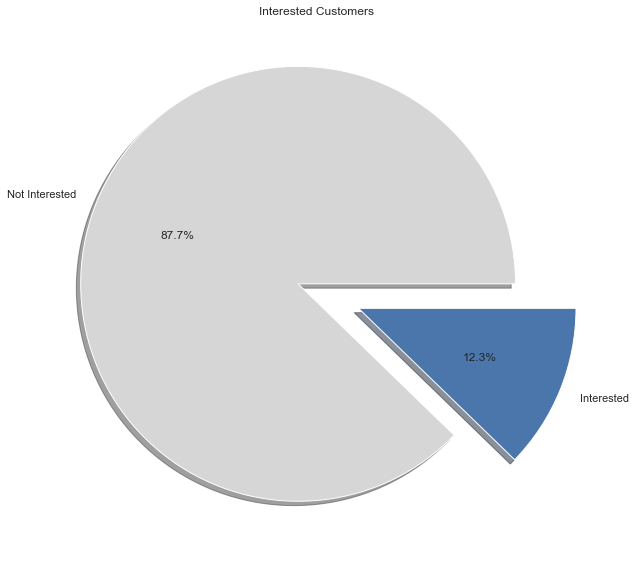

In [175]:
ax = plt.subplot (1,1,1)
ax.set_title('Interested Customers ')
aux_balance=df1['response'].value_counts()
ax = plt.pie( aux_balance, labels=['Not Interested', 'Interested'], autopct="%0.1f%%", explode=[0.1,0.2], radius=1, shadow= bool, colors=['#D6D6D6','#4A76AC'] );


## 1.5 Data Descriptive

### 1.5.1 Numerical Attributes

In [176]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

In [25]:
numerical_metrics(num_attributes)

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,id,1.0,381109.0,381108.0,190555.000000,190555.0,110016.691870,9.443274e-16,-1.200000
1,age,20.0,85.0,65.0,38.822584,36.0,15.511591,6.725390e-01,-0.565655
2,driving_license,0.0,1.0,1.0,0.997869,1.0,0.046109,-2.159518e+01,464.354302
3,region_code,0.0,52.0,52.0,26.388807,28.0,13.229871,-1.152664e-01,-0.867857
4,previously_insured,0.0,1.0,1.0,0.458210,0.0,0.498251,1.677471e-01,-1.971871
5,annual_premium,2630.0,540165.0,537535.0,30564.389581,31669.0,17213.132474,1.766087e+00,34.004569
6,policy_sales_channel,1.0,163.0,162.0,112.034295,133.0,54.203924,-9.000081e-01,-0.970810
7,vintage,10.0,299.0,289.0,154.347397,154.0,83.671194,3.029517e-03,-1.200688
8,response,0.0,1.0,1.0,0.122563,0.0,0.327935,2.301906e+00,3.298788


In [177]:
num_attributes.describe().T

,count,mean,std,min,25%,50%,75%,max
id,381109.0,190555.000000,110016.836208,1.0,95278.0,190555.0,285832.0,381109.0
age,381109.0,38.822584,15.511611,20.0,25.0,36.0,49.0,85.0
driving_license,381109.0,0.997869,0.046110,0.0,1.0,1.0,1.0,1.0
region_code,381109.0,26.388807,13.229888,0.0,15.0,28.0,35.0,52.0
previously_insured,381109.0,0.458210,0.498251,0.0,0.0,0.0,1.0,1.0
annual_premium,381109.0,30564.389581,17213.155057,2630.0,24405.0,31669.0,39400.0,540165.0
policy_sales_channel,381109.0,112.034295,54.203995,1.0,29.0,133.0,152.0,163.0
vintage,381109.0,154.347397,83.671304,10.0,82.0,154.0,227.0,299.0
response,381109.0,0.122563,0.327936,0.0,0.0,0.0,0.0,1.0


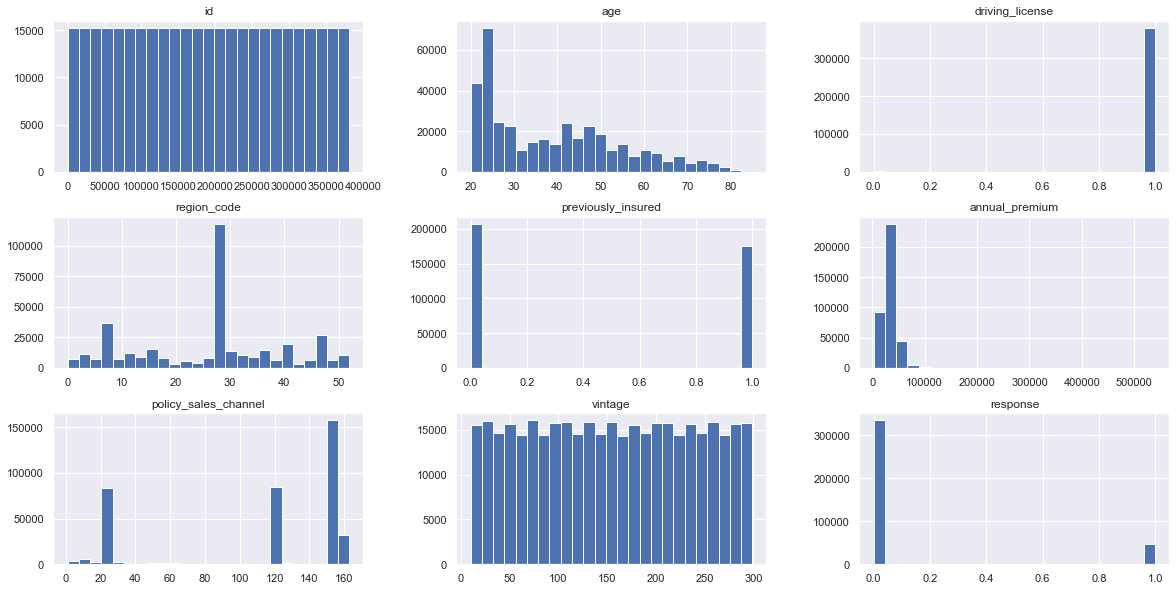

In [178]:
num_attributes.hist(bins=25);

### 1.5.2 Categorical Attributes

In [179]:
cat_attributes.describe()

,gender,vehicle_age,vehicle_damage
count,381109,381109,381109
unique,2,3,2
top,Male,1-2 Year,Yes
freq,206089,200316,192413


# 2.0 Feature Engineering

In [180]:
df2 = df1.copy()

In [181]:
df2['vehicle_age'].unique()

array(['> 2 Years', '1-2 Year', '< 1 Year'], dtype=object)

In [182]:
# vehicle_damage
df2['vehicle_damage'] = df2['vehicle_damage'].apply( lambda x: 1 if x == 'Yes' else 0 )

# vehicle_age
df2['vehicle_age'] = df2['vehicle_age']. apply( lambda x: 'over_2_years' if x == '> 2 Years' else 'between_1_2_year' if x == '1-2 Year' else 'below_1_year' )


# 3.0 Data Filtering

In [183]:
df3 = df2.copy()

# 4.0 EDA

In [184]:
df4 = df3.copy()

In [185]:
df4.columns

Index(['id', 'gender', 'age', 'driving_license', 'region_code',
       'previously_insured', 'vehicle_age', 'vehicle_damage', 'annual_premium',
       'policy_sales_channel', 'vintage', 'response'],
      dtype='object')

## 4.1 Univariate Analysis

#### Gender

Podemos notar que clientes do gênero masculino, tem mais interesse em adquirir seguro de carro.

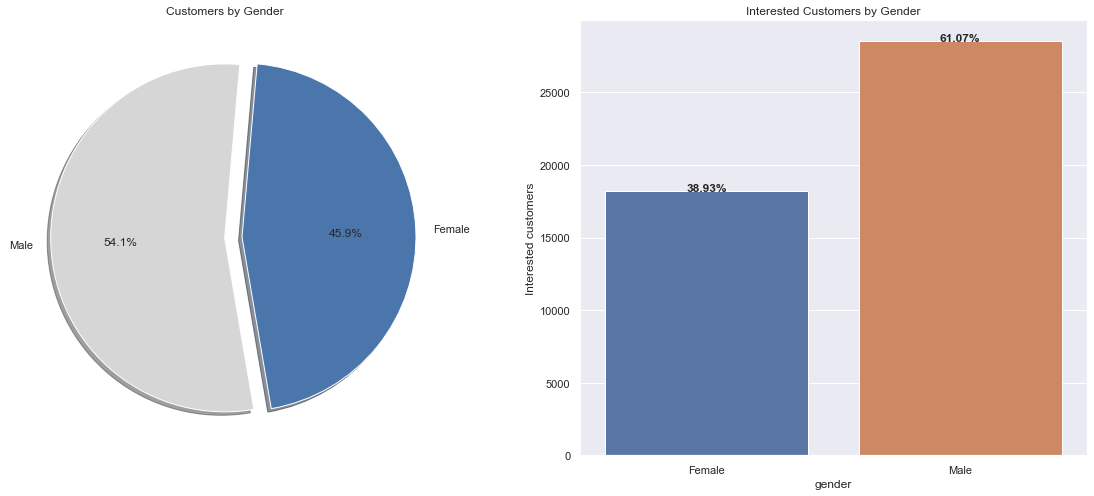

In [186]:
# Customers by gender

plt.figure(figsize=(20, 8) )
ax = plt.subplot( 1,2,1 )
aux0= df1['gender'].value_counts()
plt.pie( aux0, labels=aux0.index, autopct="%0.1f%%", explode=[0 ,0.1], radius=1, startangle=85, shadow= bool, colors=['#D6D6D6','#4A76AC'] );
ax.set_title('Customers by Gender');

# Interested Customers by gender

ax1 = plt.subplot( 1,2,2)
aux1 = df4[df4['response'] == 1]
aux1 = aux1[['gender', 'response']].groupby('gender').sum().reset_index()
h1 = sns.barplot(data=aux1, x='gender', y='response')
total = sum(aux1['response'])
ax1.set_title('Interested Customers by Gender')
ax1.set_ylabel('Interested customers');
graphic_percentage(h1,total)

#### Age

Clientes com faixa etária entre 40 e 50 anos tem mais interesse no seguro de carro. 

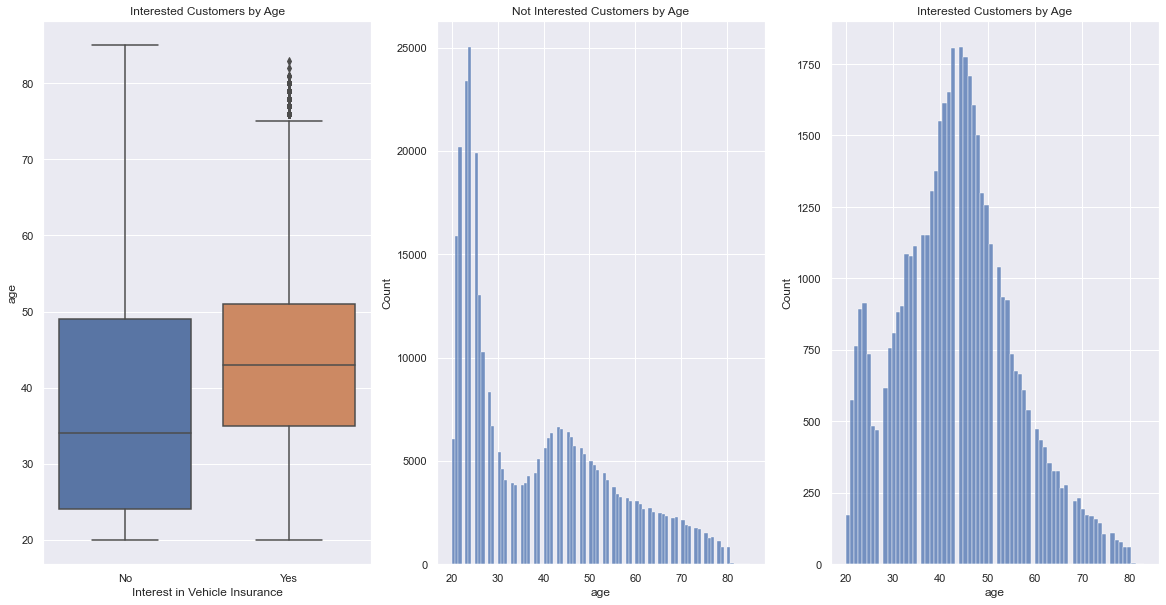

In [187]:
# age
a1 = plt.subplot(1, 3, 1)
sns.boxplot( x='response', y='age', data=df4);
a1.set_title('Interested Customers by Age')
a1.set_xlabel('Interest in Vehicle Insurance');
a1.set_xticklabels(['No', 'Yes']);

aux2 = df4.loc[df4['response'] == 0, 'age']
a2 = plt.subplot(1, 3, 2)
sns.histplot(aux2);
a2.set_title( 'Not Interested Customers by Age')

aux3 = df4.loc[df4['response'] == 1, 'age']
a3 = plt.subplot(1, 3, 3)
sns.histplot(aux3);
a3.set_title( 'Interested Customers by Age');

#### Drive License

In [188]:
# driving_license
aux4 = df4[['driving_license', 'response']].groupby('response').sum().reset_index()
aux4['percentage'] = aux4['driving_license'] / aux4['driving_license'].sum()
aux4.head()

,response,driving_license,percentage
0,0,333628,0.877283
1,1,46669,0.122717


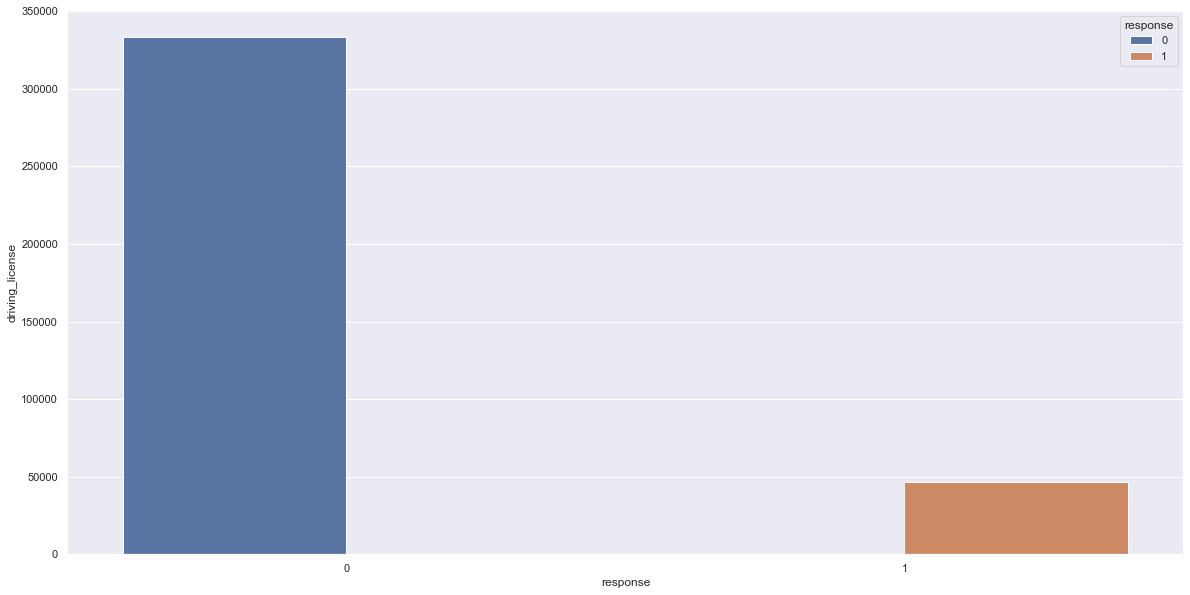

In [189]:
sns.barplot(data=aux4, x='response', y='driving_license', hue='response');

#### Region Code

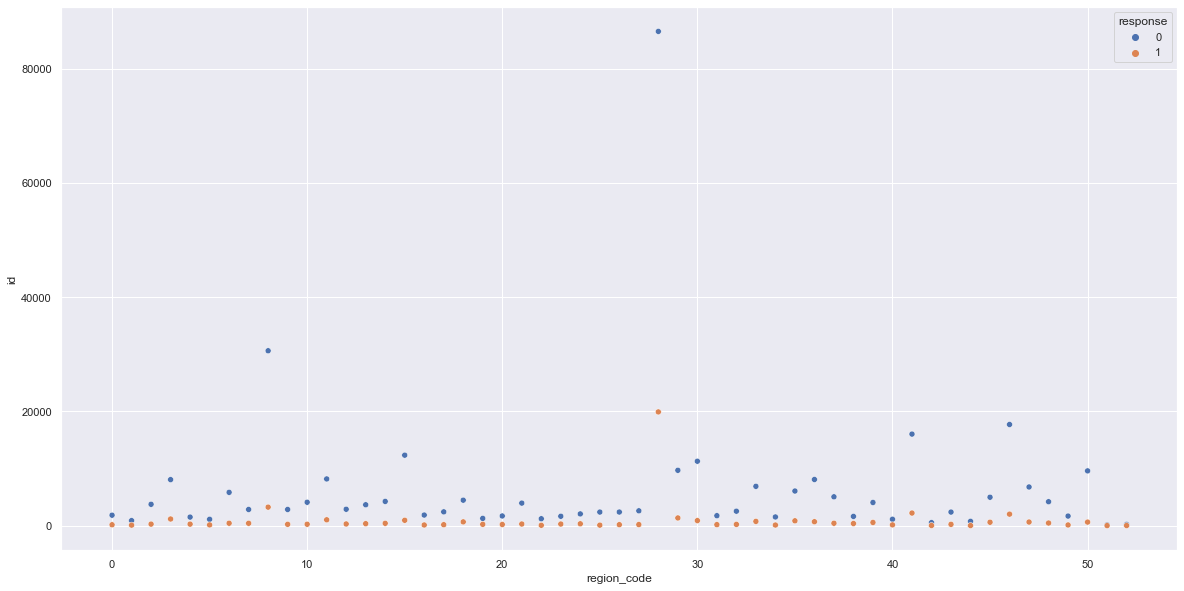

In [190]:
aux5 = df4[['id', 'region_code', 'response' ]].groupby( ['region_code', 'response']).count().reset_index()
sns.scatterplot( x='region_code', y='id', hue='response', data=aux5);


#### Previously insured

In [191]:
# previously_insured
pd.crosstab( df4['previously_insured'], df4['response'] ).apply( lambda x: x / x.sum(), axis=1 )

response,0,1
previously_insured,,
0,0.774546,0.225454
1,0.999095,0.000905


#### Vehicle Age

Embora os veículos com idade superior a 2 anos sejam muito menores em comparação aos demais, os entrevistados deste grupo demonstaram maior interesse.

In [192]:
df4[['vehicle_age', 'response']].value_counts(normalize=True, sort=False).reset_index()

,vehicle_age,response,0
0,below_1_year,0,0.413488
1,below_1_year,1,0.018897
2,between_1_2_year,0,0.434285
3,between_1_2_year,1,0.091328
4,over_2_years,0,0.029663
5,over_2_years,1,0.012338


In [193]:
#df4[['vehicle_age', 'response']].value_counts(normalize=True, sort=False).reset_index()
aux6 = pd.crosstab(df4['vehicle_age'], df4['response']).apply(lambda x: x/x.sum(), axis=1)
aux6

response,0,1
vehicle_age,,
below_1_year,0.956295,0.043705
between_1_2_year,0.826245,0.173755
over_2_years,0.706254,0.293746


#### Vehicle Damage

Veículos que já foram danificados anteriormente, apresentaram maior interesse em adquirir seguro.

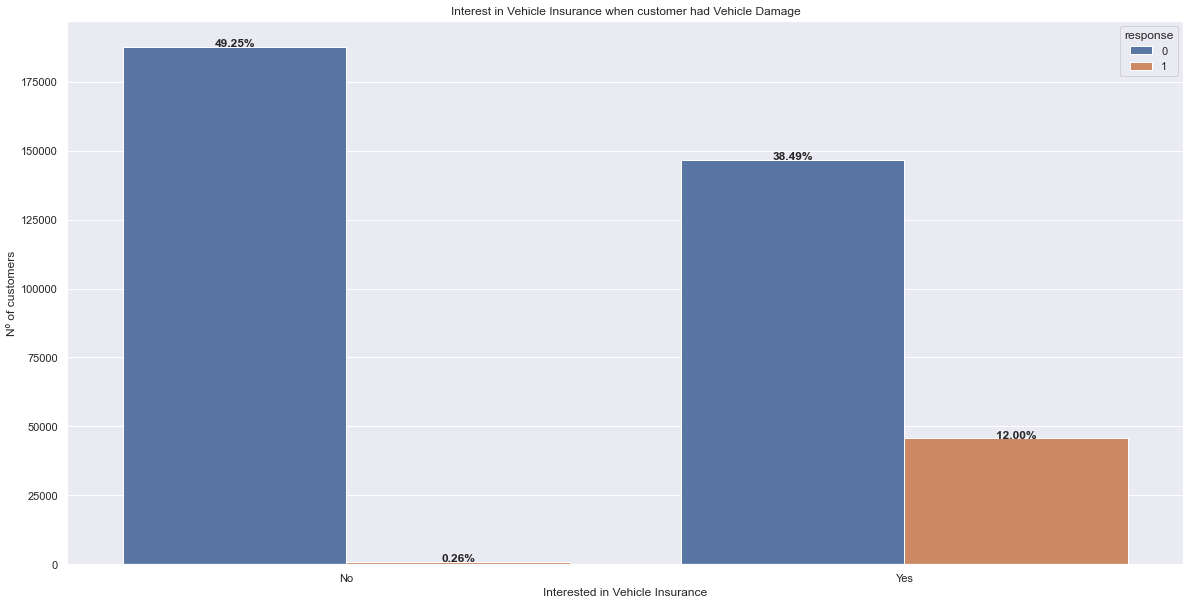

In [194]:
aux7 = df4[['vehicle_damage', 'response']].groupby(['vehicle_damage', 'response']).size().reset_index().rename(columns={0:'total'})
ax2 = sns.barplot(data=aux7, x='vehicle_damage', y='total', hue='response');
total = sum(aux7['total'])
graphic_percentage(ax2,total)
ax2.set_xlabel('Interested in Vehicle Insurance')
ax2.set_ylabel('Nº of customers')
ax2.set_title('Interest in Vehicle Insurance when customer had Vehicle Damage');
ax2.set_xticklabels(['No', 'Yes']);

In [195]:
aux7 = pd.crosstab(df4['vehicle_damage'], df4['response']).apply(lambda x: x/x.sum(), axis=1)
aux7

response,0,1
vehicle_damage,,
0,0.994796,0.005204
1,0.762345,0.237655


#### Annual Premium

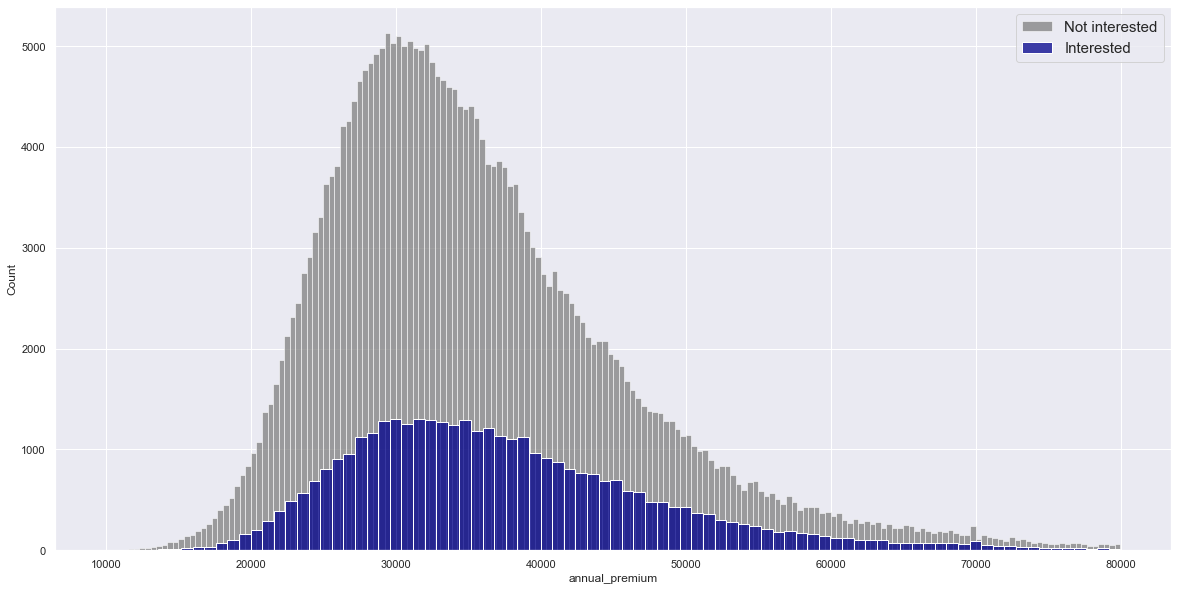

In [196]:
aux8 = df4[(df4['annual_premium'] > 10000) & (df4['annual_premium'] < 80000 )]
aux9 = aux8.loc[df4['response'] == 0, 'annual_premium']
aux10 = aux8.loc[df4['response'] == 1, 'annual_premium']


sns.histplot(aux9, color='grey', label='Not interested')
sns.histplot(aux10, color='darkblue', label='Interested')
plt.legend(fontsize=15)
plt.show()


#### Policy Sales Channel

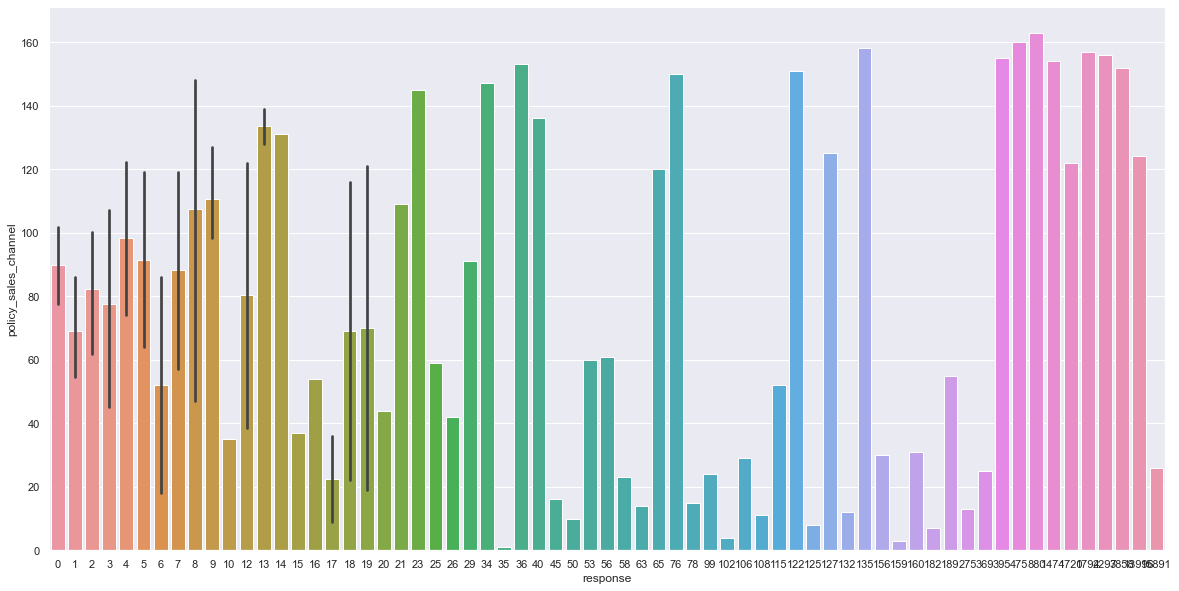

In [197]:
aux11 = df4[['policy_sales_channel', 'response']].groupby( 'policy_sales_channel' ).sum().reset_index()
sns.barplot( x='response', y='policy_sales_channel', data=aux11 );

#### Vintage

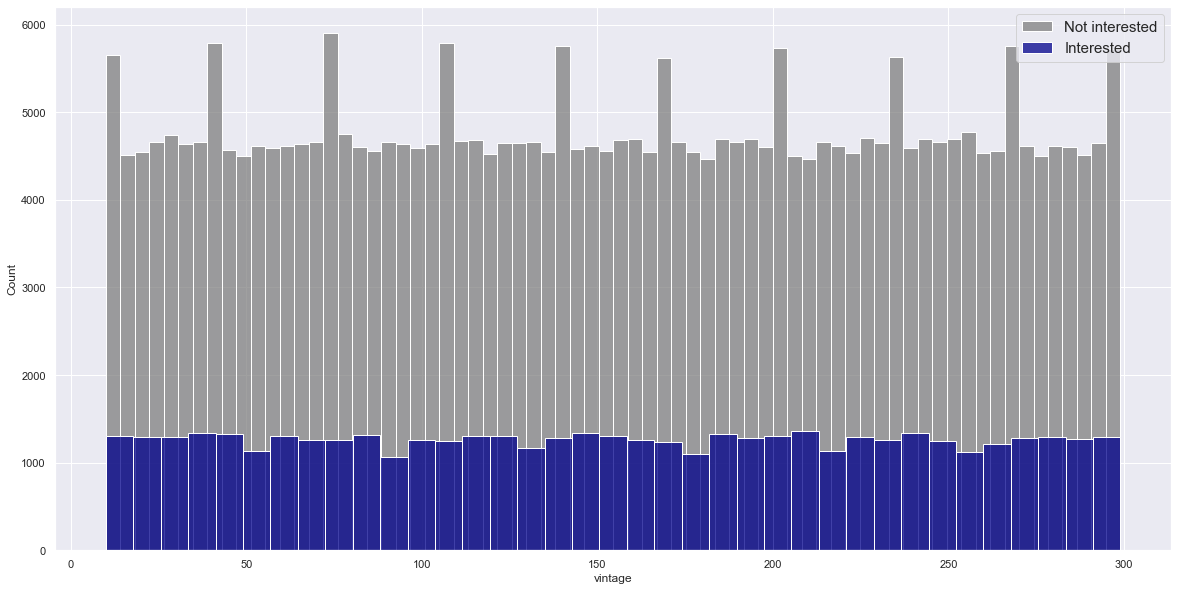

In [198]:
aux12 = df4.loc[df4['response'] == 0, 'vintage']
aux13 = df4.loc[df4['response'] == 1, 'vintage']

sns.histplot(aux12, color='grey', label='Not interested')
sns.histplot(aux13, color='darkblue', label='Interested')
plt.legend(fontsize=15)
plt.show()

## 4.2 Multivariate Analysis

# 5.0 Data Preparation

In [199]:
X = df4.drop( 'response', axis=1 )
y = df4['response'].copy() 

x_train, x_validation, y_train, y_validation = ms.train_test_split( X, y, test_size=0.20, random_state=42 )

df5 = pd.concat( [x_train, y_train], axis=1 )

In [200]:
# shape of trains, tests and vals
print("x_train & y_train size")
print(x_train.shape)
print(y_train.shape)

print("\nx_val & y_val size")
print(x_validation.shape)
print(y_validation.shape)

x_train & y_train size
(304887, 11)
(304887,)

x_val & y_val size
(76222, 11)
(76222,)


## 5.1 Standardization

In [201]:
ss = pp.StandardScaler()

# anual premium - StandarScaler
df5['annual_premium'] = ss.fit_transform( df5[['annual_premium']].values )
pickle.dump( ss, open('C:\\Users\\Codo\\Desktop\\repos\\PA_health_insurance\\src\\features\\annual_premium_scaler.pkl', 'wb' ))

## 5.2 Rescailing

In [202]:
mms_age = pp.MinMaxScaler()
mms_vintage = pp.MinMaxScaler()

# age - MinMaxScaler
df5['age'] = mms_age.fit_transform( df5[['age']].values )
pickle.dump( mms_age, open('C:\\Users\\Codo\\Desktop\\repos\\PA_health_insurance\\src\\features\\age_scaler.pkl', 'wb') )

# vintage - MinMaxScaler
df5['vintage'] = mms_vintage.fit_transform( df5[['vintage']].values )
pickle.dump( mms_vintage, open('C:\\Users\\Codo\\Desktop\\repos\\PA_health_insurance\\src\\features\\vintage_scaler.pkl', 'wb') )

## 5.3 Transformation

In [203]:
x_validation.head()

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage
200222,200223,Female,21,1,3,1,below_1_year,0,20408.0,160,72
49766,49767,Male,55,1,15,0,between_1_2_year,1,37498.0,26,102
172201,172202,Female,41,1,3,0,between_1_2_year,1,2630.0,26,90
160713,160714,Female,26,1,11,0,below_1_year,0,2630.0,151,268
53272,53273,Male,51,1,40,0,between_1_2_year,1,34006.0,124,265


## 5.3.1  Encoding

In [204]:
 # gender - One Hot Encoding / Target Encoding
target_encode_gender = df5.groupby( 'gender' )['response'].mean()
df5.loc[:, 'gender'] = df5['gender'].map( target_encode_gender )
pickle.dump( target_encode_gender, open('C:\\Users\\Codo\\Desktop\\repos\\PA_health_insurance\\src\\features\\target_encode_gender_scaler.pkl', 'wb') )

# region_code - Target Encoding / Frequency Encoding
target_encode_region_code = df5.groupby( 'region_code' )['response'].mean()
df5.loc[:, 'region_code'] = df5['region_code'].map( target_encode_region_code )
pickle.dump( target_encode_region_code, open('C:\\Users\\Codo\\Desktop\\repos\\PA_health_insurance\\src\\features\\target_encode_region_code_scaler.pkl', 'wb') )

# vehicle_age - One Hot Enconding / Frequency Enconding 
df5 = pd.get_dummies( df5, prefix='vehicle_age', columns=['vehicle_age'] )

# policy_sales_channel - Target Encoding / Frequency Encoding
fe_policy_sales_channel = df5.groupby( 'policy_sales_channel' ).size() / len( df5 ) 
df5.loc[:, 'policy_sales_channel'] = df5['policy_sales_channel'].map( fe_policy_sales_channel )
pickle.dump( fe_policy_sales_channel, open('C:\\Users\\Codo\\Desktop\\repos\\PA_health_insurance\\src\\features\\fe_policy_sales_channel_scaler.pkl', 'wb') )

In [205]:
df5.head()

,id,gender,age,driving_license,region_code,previously_insured,vehicle_damage,annual_premium,policy_sales_channel,vintage,response,vehicle_age_below_1_year,vehicle_age_between_1_2_year,vehicle_age_over_2_years
332803,332804,0.103373,0.292308,1,0.070151,0,1,1.294417,0.003309,0.750865,1,0,1,0
116248,116249,0.137774,0.276923,1,0.109796,0,1,-0.436638,0.209638,0.065744,0,0,1,0
255005,255006,0.137774,0.030769,1,0.074305,1,0,0.854640,0.353472,0.539792,0,1,0,0
317474,317475,0.103373,0.046154,1,0.122946,1,0,-0.083449,0.010050,0.923875,0,1,0,0
344212,344213,0.137774,0.553846,1,0.100978,0,1,-1.619422,0.015901,0.501730,0,0,0,1


## 5.4 Validation Preparation

In [206]:
 # gender
x_validation.loc[:, 'gender'] =  x_validation.loc[:, 'gender'].map( target_encode_gender )

# age
x_validation.loc[:, 'age'] = mms_age.transform( x_validation[['age']].values )

# region_code
x_validation.loc[:, 'region_code'] = x_validation.loc[:, 'region_code'].map( target_encode_region_code )

# vehicle_age
x_validation = pd.get_dummies( x_validation, prefix='vehicle_age', columns=['vehicle_age'] )

# annual_premium
x_validation.loc[:, 'annual_premium'] = ss.transform( x_validation[['annual_premium']].values )

# policy_sales_channel
x_validation.loc[:, 'policy_sales_channel'] = x_validation['policy_sales_channel'].map( fe_policy_sales_channel )

# vintage
x_validation.loc[:, 'vintage'] = mms_vintage.transform( x_validation[['vintage']].values )

# fillna
x_validation = x_validation.fillna( 0 )

In [207]:
x_validation.head()

,id,gender,age,driving_license,region_code,previously_insured,vehicle_damage,annual_premium,policy_sales_channel,vintage,vehicle_age_below_1_year,vehicle_age_between_1_2_year,vehicle_age_over_2_years
200222,200223,0.103373,0.015385,1,0.126795,1,0,-0.589065,0.056874,0.214533,1,0,0
49766,49767,0.137774,0.538462,1,0.070151,0,1,0.401418,0.209638,0.318339,0,1,0
172201,172202,0.103373,0.323077,1,0.126795,0,1,-1.619422,0.209638,0.276817,0,1,0
160713,160714,0.103373,0.092308,1,0.109796,0,0,-1.619422,0.010050,0.892734,1,0,0
53272,53273,0.137774,0.476923,1,0.121270,0,1,0.199032,0.193934,0.882353,0,1,0


# 6.0 Feature Sellection

## 6.1 Important features

In [208]:
# data preparation
x_train_n = df5.drop( ['id', 'response'], axis=1 )
y_train_n = y_train.values

### 6.1.1 ExtraTree

Feature ranking:
                        feature  importance
0                       vintage    0.273060
0                annual_premium    0.245104
0                           age    0.164858
0                   region_code    0.106965
0                vehicle_damage    0.066324
0          policy_sales_channel    0.059156
0            previously_insured    0.057517
0      vehicle_age_below_1_year    0.013606
0  vehicle_age_between_1_2_year    0.006103
0                        gender    0.004627
0      vehicle_age_over_2_years    0.002176
0               driving_license    0.000503


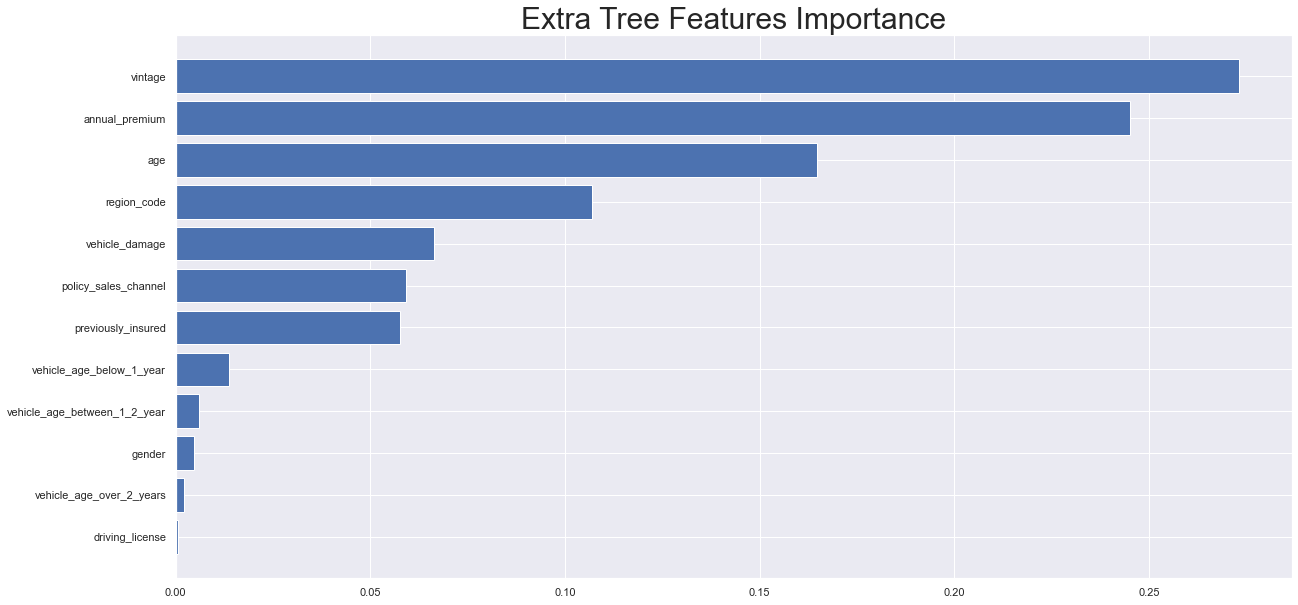

In [209]:
forest = en.ExtraTreesClassifier( n_estimators=250, random_state=0, n_jobs=-1 )
forest.fit( x_train_n, y_train_n)

importances = forest.feature_importances_.argsort()

# Print the feature ranking
print("Feature ranking:")
df = pd.DataFrame()
for i, j in zip( x_train_n, forest.feature_importances_ ):
    aux = pd.DataFrame( {'feature': i, 'importance': j}, index=[0] )
    df = pd.concat( [df, aux], axis=0 )
    
print( df.sort_values( 'importance', ascending=False ) )

# plot
plt.barh(x_train_n.columns[importances], forest.feature_importances_[importances])
plt.title('Extra Tree Features Importance', fontsize=30);


### 6.1.2 Random Forest

Feature ranking:
                        feature  importance
0                       vintage    0.282855
0                annual_premium    0.254939
0                           age    0.147960
0                   region_code    0.095116
0          policy_sales_channel    0.074087
0                vehicle_damage    0.063810
0            previously_insured    0.055536
0                        gender    0.009660
0      vehicle_age_below_1_year    0.009502
0  vehicle_age_between_1_2_year    0.003927
0      vehicle_age_over_2_years    0.002079
0               driving_license    0.000528


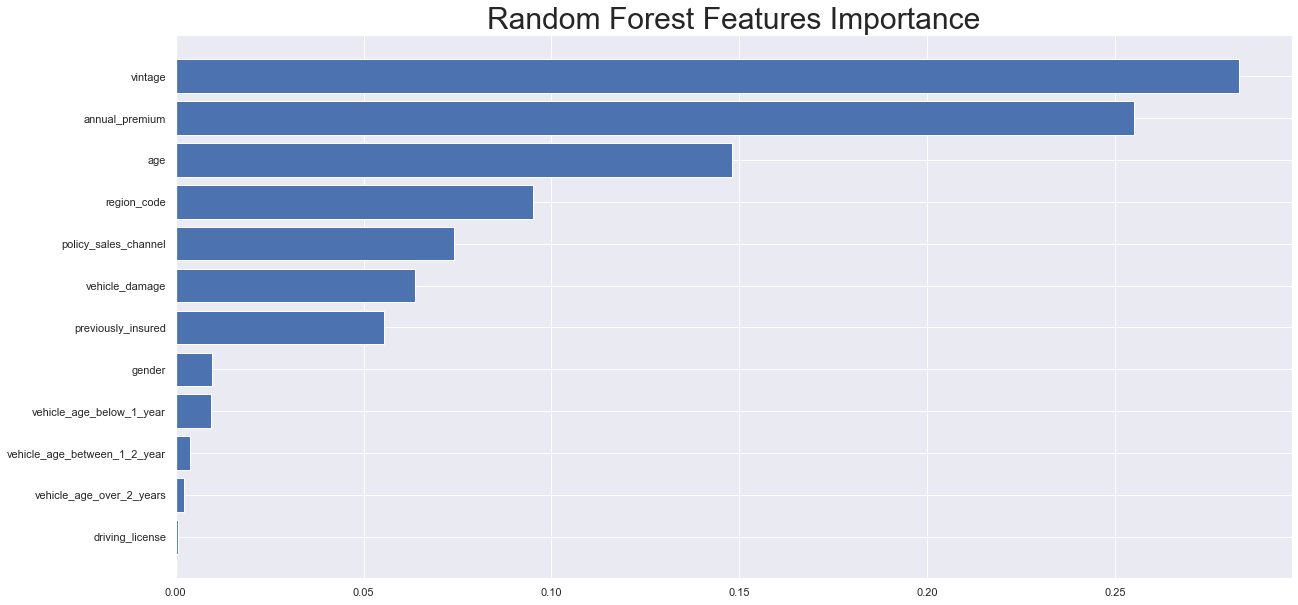

In [210]:
rf_selector = RandomForestClassifier(max_depth=100, n_jobs=-1)
rf_selector.fit(x_train_n, y_train_n)
rf_selector.feature_importances_

# Print the feature ranking
print("Feature ranking:")
df = pd.DataFrame()
for i, j in zip( x_train_n, rf_selector.feature_importances_ ):
    aux = pd.DataFrame( {'feature': i, 'importance': j}, index=[0] )
    df = pd.concat( [df, aux], axis=0 )
    
print( df.sort_values( 'importance', ascending=False ) )

sorted_features = rf_selector.feature_importances_.argsort()

plt.barh(x_train_n.columns[sorted_features], rf_selector.feature_importances_[sorted_features])
plt.title('Random Forest Features Importance', fontsize=30);


# 7.0 Machine Learning 

In [211]:
cols_selected = ['annual_premium', 'vintage', 'age', 'region_code', 'vehicle_damage', 'previously_insured', 'policy_sales_channel']

x_train = df5[ cols_selected ]
x_val = x_validation[ cols_selected ]
y_val = y_validation.copy()

## 7.1 Logistic Regression

In [52]:
 # model definition
lr_model = lm.LogisticRegression( random_state=42 ) 

df_lr = metrics_at_k(lr_model, x_train, y_train, x_val, y_val )
df_lr

,Model_Name,Model Accuracy,Precision @K,Recall @K,ROC AUC Score,Top K Score
0,LogisticRegression,0.875062,0.288686,0.606322,0.817302,0.875062


## 7.2 KNN Classifier

In [53]:
# model definition
knn_model = nh.KNeighborsClassifier( n_neighbors=7, n_jobs=-1 )

df_knn = metrics_at_k(knn_model, x_train, y_train, x_val, y_val )
df_knn

,Model_Name,Model Accuracy,Precision @K,Recall @K,ROC AUC Score,Top K Score
0,KNeighborsClassifier,0.85802,0.299635,0.629318,0.782844,0.85802


## 7.3 Random Forest

In [54]:
# model definition
rf_model = en.RandomForestClassifier( n_estimators=1000, n_jobs=-1, random_state=42 )

df_rf = metrics_at_k(rf_model, x_train, y_train, x_val, y_val )
df_rf


,Model_Name,Model Accuracy,Precision @K,Recall @K,ROC AUC Score,Top K Score
0,RandomForestClassifier,0.864094,0.319434,0.670902,0.838271,0.864094


## 7.4 LGBM

In [55]:
# model definition
lgbm_model = LGBMClassifier(random_state=42, n_jobs=-1)

df_lgbm = metrics_at_k(lgbm_model, x_train, y_train, x_val, y_val )
df_lgbm

,Model_Name,Model Accuracy,Precision @K,Recall @K,ROC AUC Score,Top K Score
0,LGBMClassifier,0.874761,0.343133,0.720676,0.857903,0.874761


## 7.5 Catboost

In [56]:
# model definition
ctb_model = CatBoostClassifier(random_state=42, verbose=False)

df_ctb = metrics_at_k(ctb_model, x_train, y_train, x_val, y_val )
df_ctb

,Model_Name,Model Accuracy,Precision @K,Recall @K,ROC AUC Score,Top K Score
0,CatBoostClassifier,0.874498,0.340833,0.715846,0.856752,0.874498


## 7.6 XGBClassifier

In [57]:
# model definition
xgb_model = XGBClassifier( random_state=42, n_jobs=-1)

df_xgb = metrics_at_k(xgb_model, x_train, y_train, x_val, y_val )
df_xgb

,Model_Name,Model Accuracy,Precision @K,Recall @K,ROC AUC Score,Top K Score
0,XGBClassifier,0.874892,0.340933,0.716056,0.856461,0.874892


# 8.0 Model Performance

## 8.1 Single Performance

In [67]:
model_performance_single = pd.concat([df_lr,df_knn,df_rf,df_lgbm,df_ctb, df_xgb ] )
model_performance_single.sort_values('Recall @K', ascending=False)

,Model_Name,Model Accuracy,Precision @K,Recall @K,ROC AUC Score,Top K Score
0,LGBMClassifier,0.874761,0.343133,0.720676,0.857903,0.874761
0,XGBClassifier,0.874892,0.340933,0.716056,0.856461,0.874892
0,CatBoostClassifier,0.874498,0.340833,0.715846,0.856752,0.874498
0,RandomForestClassifier,0.864094,0.319434,0.670902,0.838271,0.864094
0,KNeighborsClassifier,0.858020,0.299635,0.629318,0.782844,0.858020
0,LogisticRegression,0.875062,0.288686,0.606322,0.817302,0.875062


## 8.2 Real Performance - Cross Validation

In [62]:
lr_cv = cross_validation(lr_model, x_train, y_train, 5, verbose=False)
knn_cv = cross_validation(knn_model, x_train, y_train, 5, verbose=False)
rf_cv = cross_validation(rf_model, x_train, y_train, 5, verbose=False)
lgbm_cv = cross_validation(lgbm_model, x_train, y_train, 5, verbose=False)
ctb_cv = cross_validation(ctb_model, x_train, y_train, 5, verbose=False)
xgb_cv = cross_validation(xgb_model, x_train, y_train, 5, verbose=False)

In [68]:
model_performance_cv = pd.concat([lr_cv,knn_cv,rf_cv,lgbm_cv,ctb_cv,xgb_cv ] )
model_performance_cv.sort_values('Recall @K Mean', ascending=False)

,Model Name,Model Accuracy,Precision @K Mean,Recall @K Mean,ROC AUC Score,Top @K Mean
0,LGBMClassifier CV,0.5+/-0.0,0.308+/-0.002,0.828+/-0.005,0.854+/-0.002,0.878+/-0.0
0,CatBoostClassifier CV,0.505+/-0.001,0.308+/-0.001,0.828+/-0.003,0.853+/-0.001,0.877+/-0.0
0,XGBClassifier CV,0.505+/-0.001,0.307+/-0.001,0.826+/-0.004,0.852+/-0.001,0.877+/-0.0
0,RandomForestClassifier CV,0.542+/-0.001,0.291+/-0.001,0.782+/-0.003,0.833+/-0.001,0.866+/-0.001
0,LogisticRegression CV,0.5+/-0.0,0.275+/-0.002,0.739+/-0.005,0.818+/-0.002,0.878+/-0.0
0,KNeighborsClassifier CV,0.547+/-0.001,0.273+/-0.001,0.734+/-0.002,0.782+/-0.0,0.861+/-0.0


# 9.0 Hyperparameter fine Tuning

In [228]:
def objective(trial):
    

    param_grid = {
        
        "n_estimators": trial.suggest_int("n_estimators", 500, 1700),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "num_leaves": trial.suggest_int('num_leaves', 20, 3000),
        "min_data_in_leaf": 100,
        "min_split_gain" : trial.suggest_float('min_split_gain', 0.01, 0.1), 
        "min_child_weight" :trial.suggest_int('min_child_weight', 10, 75),
        "subsample":  trial.suggest_float('subsample', 0.1, 1),
        "colsample_bytree": trial.suggest_float('colsample_bytree', 0.4, 1),
        "min_child_samples" : trial.suggest_int('min_child_samples', 1, 7)

    }

    model = LGBMClassifier(**param_grid)

    model.fit(x_train, y_train)

    yhat_lgbm = model.predict(x_val)
    yhat_lgbm_proba = model.predict_proba(x_val)

    data = x_val.copy()
    data['response'] = y_validation.copy()
    data['score'] = yhat_lgbm_proba[:,1].tolist()
    data = data.sort_values('score',ascending=False)    

    knum = y_validation.value_counts().count()-1

    auc_roc = roc_auc_score(y_val, yhat_lgbm_proba[:, 1])
    

    return auc_roc

In [229]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30);

trial = study.best_trial

print('Best ROC AUC Score: {}'.format(trial.value))
print('Best hyperparam: {}'.format(trial.params))

[I 2023-01-08 22:37:00,415] A new study created in memory with name: no-name-93c496ab-6e6e-473e-884a-4cc8d3de9529


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


[I 2023-01-08 22:37:03,961] Trial 0 finished with value: 0.8539563627717423 and parameters: {'n_estimators': 542, 'max_depth': 10, 'num_leaves': 2077, 'min_split_gain': 0.011110724366159723, 'min_child_weight': 68, 'subsample': 0.1339080794748644, 'colsample_bytree': 0.7829928356334825}. Best is trial 0 with value: 0.8539563627717423.


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


[I 2023-01-08 22:37:06,196] Trial 1 finished with value: 0.8582046530807546 and parameters: {'n_estimators': 1384, 'max_depth': 5, 'num_leaves': 1887, 'min_split_gain': 0.08882648642731517, 'min_child_weight': 49, 'subsample': 0.5078304911257142, 'colsample_bytree': 0.9044770943431685}. Best is trial 1 with value: 0.8582046530807546.


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


[I 2023-01-08 22:37:08,797] Trial 2 finished with value: 0.8576725056802769 and parameters: {'n_estimators': 1652, 'max_depth': 9, 'num_leaves': 1960, 'min_split_gain': 0.08795622621597798, 'min_child_weight': 63, 'subsample': 0.6691661956741359, 'colsample_bytree': 0.6398485162486631}. Best is trial 1 with value: 0.8582046530807546.


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


[I 2023-01-08 22:37:12,334] Trial 3 finished with value: 0.8568928342042255 and parameters: {'n_estimators': 1392, 'max_depth': 5, 'num_leaves': 1784, 'min_split_gain': 0.018964585219823422, 'min_child_weight': 32, 'subsample': 0.10491344015724507, 'colsample_bytree': 0.6270048912081067}. Best is trial 1 with value: 0.8582046530807546.


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


[I 2023-01-08 22:37:14,114] Trial 4 finished with value: 0.8567564260368691 and parameters: {'n_estimators': 625, 'max_depth': 12, 'num_leaves': 1472, 'min_split_gain': 0.09362817386859155, 'min_child_weight': 67, 'subsample': 0.32659801322816184, 'colsample_bytree': 0.6251024377087924}. Best is trial 1 with value: 0.8582046530807546.


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


[I 2023-01-08 22:37:16,199] Trial 5 finished with value: 0.8557805470857187 and parameters: {'n_estimators': 560, 'max_depth': 9, 'num_leaves': 88, 'min_split_gain': 0.02791729959790451, 'min_child_weight': 26, 'subsample': 0.8221025103085999, 'colsample_bytree': 0.7275096056207724}. Best is trial 1 with value: 0.8582046530807546.


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


[I 2023-01-08 22:37:19,029] Trial 6 finished with value: 0.85643291104203 and parameters: {'n_estimators': 1642, 'max_depth': 12, 'num_leaves': 2745, 'min_split_gain': 0.0816690562811374, 'min_child_weight': 40, 'subsample': 0.8179947418586491, 'colsample_bytree': 0.44698680263205076}. Best is trial 1 with value: 0.8582046530807546.


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


[I 2023-01-08 22:37:21,207] Trial 7 finished with value: 0.8564113335096533 and parameters: {'n_estimators': 691, 'max_depth': 7, 'num_leaves': 1004, 'min_split_gain': 0.021226729577864624, 'min_child_weight': 16, 'subsample': 0.8227552451139485, 'colsample_bytree': 0.49905020492173613}. Best is trial 1 with value: 0.8582046530807546.


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


[I 2023-01-08 22:37:23,335] Trial 8 finished with value: 0.858680484467816 and parameters: {'n_estimators': 1229, 'max_depth': 4, 'num_leaves': 2607, 'min_split_gain': 0.09783388005646032, 'min_child_weight': 72, 'subsample': 0.569482496547728, 'colsample_bytree': 0.6482054041328529}. Best is trial 8 with value: 0.858680484467816.


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


[I 2023-01-08 22:37:26,102] Trial 9 finished with value: 0.8560622806539059 and parameters: {'n_estimators': 1437, 'max_depth': 12, 'num_leaves': 1600, 'min_split_gain': 0.06380624053365447, 'min_child_weight': 53, 'subsample': 0.3394753925171229, 'colsample_bytree': 0.5928742827751116}. Best is trial 8 with value: 0.858680484467816.


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


[I 2023-01-08 22:37:29,008] Trial 10 finished with value: 0.8583468187203593 and parameters: {'n_estimators': 966, 'max_depth': 3, 'num_leaves': 2884, 'min_split_gain': 0.04664114336512181, 'min_child_weight': 74, 'subsample': 0.9950560567259428, 'colsample_bytree': 0.9573915332023898}. Best is trial 8 with value: 0.858680484467816.


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


[I 2023-01-08 22:37:31,482] Trial 11 finished with value: 0.8582722636268233 and parameters: {'n_estimators': 998, 'max_depth': 3, 'num_leaves': 2865, 'min_split_gain': 0.041260658815032186, 'min_child_weight': 71, 'subsample': 0.996463157351693, 'colsample_bytree': 0.9716131805525228}. Best is trial 8 with value: 0.858680484467816.


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


[I 2023-01-08 22:37:33,741] Trial 12 finished with value: 0.8584571962488985 and parameters: {'n_estimators': 1043, 'max_depth': 3, 'num_leaves': 2487, 'min_split_gain': 0.06231739220934142, 'min_child_weight': 75, 'subsample': 0.9843495942863768, 'colsample_bytree': 0.8272985685940419}. Best is trial 8 with value: 0.858680484467816.


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


[I 2023-01-08 22:37:36,004] Trial 13 finished with value: 0.8578095640625742 and parameters: {'n_estimators': 1153, 'max_depth': 5, 'num_leaves': 2384, 'min_split_gain': 0.06576702048482874, 'min_child_weight': 57, 'subsample': 0.5801300591269565, 'colsample_bytree': 0.81432069547137}. Best is trial 8 with value: 0.858680484467816.


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


[I 2023-01-08 22:37:38,359] Trial 14 finished with value: 0.8583670942484842 and parameters: {'n_estimators': 1217, 'max_depth': 4, 'num_leaves': 2428, 'min_split_gain': 0.07188780818916586, 'min_child_weight': 60, 'subsample': 0.410622557984589, 'colsample_bytree': 0.8416529175132547}. Best is trial 8 with value: 0.858680484467816.


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


[I 2023-01-08 22:37:40,028] Trial 15 finished with value: 0.8582706483228785 and parameters: {'n_estimators': 860, 'max_depth': 7, 'num_leaves': 997, 'min_split_gain': 0.09921249877477394, 'min_child_weight': 45, 'subsample': 0.6960914114251026, 'colsample_bytree': 0.7221465627185621}. Best is trial 8 with value: 0.858680484467816.


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


[I 2023-01-08 22:37:42,543] Trial 16 finished with value: 0.8581586869778007 and parameters: {'n_estimators': 1256, 'max_depth': 6, 'num_leaves': 2478, 'min_split_gain': 0.05434105446205328, 'min_child_weight': 75, 'subsample': 0.8776236847089653, 'colsample_bytree': 0.5340838053341358}. Best is trial 8 with value: 0.858680484467816.


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


[I 2023-01-08 22:37:44,760] Trial 17 finished with value: 0.8585838370228095 and parameters: {'n_estimators': 828, 'max_depth': 3, 'num_leaves': 2211, 'min_split_gain': 0.07714218680160839, 'min_child_weight': 61, 'subsample': 0.6634104608168314, 'colsample_bytree': 0.8849222196285634}. Best is trial 8 with value: 0.858680484467816.


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


[I 2023-01-08 22:37:46,696] Trial 18 finished with value: 0.858443059977824 and parameters: {'n_estimators': 777, 'max_depth': 4, 'num_leaves': 1227, 'min_split_gain': 0.07681283332273485, 'min_child_weight': 62, 'subsample': 0.6589054648566218, 'colsample_bytree': 0.9175065923460818}. Best is trial 8 with value: 0.858680484467816.


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


[I 2023-01-08 22:37:48,479] Trial 19 finished with value: 0.8583698399503166 and parameters: {'n_estimators': 834, 'max_depth': 4, 'num_leaves': 2158, 'min_split_gain': 0.07975549892921635, 'min_child_weight': 38, 'subsample': 0.47646665386647025, 'colsample_bytree': 0.6849447855723152}. Best is trial 8 with value: 0.858680484467816.


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


[I 2023-01-08 22:37:50,740] Trial 20 finished with value: 0.8582914504778739 and parameters: {'n_estimators': 1509, 'max_depth': 6, 'num_leaves': 103, 'min_split_gain': 0.09788560460591016, 'min_child_weight': 54, 'subsample': 0.5872891277392784, 'colsample_bytree': 0.4055450514165085}. Best is trial 8 with value: 0.858680484467816.


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


[I 2023-01-08 22:37:53,031] Trial 21 finished with value: 0.8585123881619083 and parameters: {'n_estimators': 1043, 'max_depth': 3, 'num_leaves': 2647, 'min_split_gain': 0.06245617570968127, 'min_child_weight': 65, 'subsample': 0.7243350028524701, 'colsample_bytree': 0.8653881833159975}. Best is trial 8 with value: 0.858680484467816.


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


[I 2023-01-08 22:37:55,285] Trial 22 finished with value: 0.8585467944508113 and parameters: {'n_estimators': 911, 'max_depth': 3, 'num_leaves': 2703, 'min_split_gain': 0.0501621415053692, 'min_child_weight': 66, 'subsample': 0.733812605548959, 'colsample_bytree': 0.877625114386349}. Best is trial 8 with value: 0.858680484467816.


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


[I 2023-01-08 22:37:57,529] Trial 23 finished with value: 0.8580765867145217 and parameters: {'n_estimators': 906, 'max_depth': 4, 'num_leaves': 2215, 'min_split_gain': 0.04231736909047269, 'min_child_weight': 49, 'subsample': 0.74267586403668, 'colsample_bytree': 0.769691509030292}. Best is trial 8 with value: 0.858680484467816.


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


[I 2023-01-08 22:37:59,822] Trial 24 finished with value: 0.8576580458761027 and parameters: {'n_estimators': 726, 'max_depth': 6, 'num_leaves': 2954, 'min_split_gain': 0.052286785232653725, 'min_child_weight': 68, 'subsample': 0.5623642225118818, 'colsample_bytree': 0.9002333721607958}. Best is trial 8 with value: 0.858680484467816.


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


[I 2023-01-08 22:38:02,910] Trial 25 finished with value: 0.8581126390075906 and parameters: {'n_estimators': 1110, 'max_depth': 3, 'num_leaves': 2676, 'min_split_gain': 0.03435879684096135, 'min_child_weight': 58, 'subsample': 0.6320023776941073, 'colsample_bytree': 0.7665510834331909}. Best is trial 8 with value: 0.858680484467816.


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


[I 2023-01-08 22:38:05,283] Trial 26 finished with value: 0.8580871176775704 and parameters: {'n_estimators': 1235, 'max_depth': 5, 'num_leaves': 2259, 'min_split_gain': 0.07375405709450689, 'min_child_weight': 70, 'subsample': 0.4512852929354729, 'colsample_bytree': 0.9913329295346041}. Best is trial 8 with value: 0.858680484467816.


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


[I 2023-01-08 22:38:07,209] Trial 27 finished with value: 0.8584646186177569 and parameters: {'n_estimators': 919, 'max_depth': 4, 'num_leaves': 404, 'min_split_gain': 0.08662747712674844, 'min_child_weight': 63, 'subsample': 0.7471901147976723, 'colsample_bytree': 0.6843348721192807}. Best is trial 8 with value: 0.858680484467816.


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


[I 2023-01-08 22:38:09,707] Trial 28 finished with value: 0.8584609944172875 and parameters: {'n_estimators': 1318, 'max_depth': 3, 'num_leaves': 2998, 'min_split_gain': 0.06968264878670952, 'min_child_weight': 10, 'subsample': 0.37950735713501393, 'colsample_bytree': 0.5615556191915279}. Best is trial 8 with value: 0.858680484467816.


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


[I 2023-01-08 22:38:11,776] Trial 29 finished with value: 0.8570344000087398 and parameters: {'n_estimators': 783, 'max_depth': 8, 'num_leaves': 2063, 'min_split_gain': 0.05732481561891375, 'min_child_weight': 70, 'subsample': 0.9060661525471634, 'colsample_bytree': 0.7946506392620469}. Best is trial 8 with value: 0.858680484467816.


Best ROC AUC Score: 0.858680484467816
Best hyperparam: {'n_estimators': 1229, 'max_depth': 4, 'num_leaves': 2607, 'min_split_gain': 0.09783388005646032, 'min_child_weight': 72, 'subsample': 0.569482496547728, 'colsample_bytree': 0.6482054041328529}


# 10.0 Final Model

In [212]:
param_tuned = {'n_estimators': 1556, 'max_depth': 4, 'num_leaves': 1058, 'min_split_gain': 0.07650479184993597, 'min_child_weight': 45, 'subsample': 0.8342953457368258, 'colsample_bytree': 0.5281120352667489, 'min_child_samples': 3}

In [213]:
lgbm_tuned = LGBMClassifier(**param_tuned).fit(x_train,y_train)


In [222]:
# save trained model
#pickle.dump( lgbm_tuned, open('C:\\Users\\Codo\\Desktop\\repos\\PA_health_insurance\\src\\models\\lgbm_tuned.pkl', 'wb') )

In [214]:
lgb_cv = cross_validation(lgbm_tuned, x_train, y_train, 5, verbose=False)

lgb_cv

,Model Name,Model Accuracy,Precision @K Mean,Recall @K Mean,ROC AUC Score,Top @K Mean
0,LGBMClassifier CV,0.502+/-0.0,0.309+/-0.001,0.831+/-0.004,0.855+/-0.002,0.878+/-0.0


# 11.0 Business Perfomance

In [215]:
# predictions
yhat_lgbm_final = lgbm_tuned.predict_proba(x_val)


data = x_validation.copy()
data['response'] = y_validation.copy()
data['score'] = yhat_lgbm_final[:, 1].tolist()
data = data.sort_values('score', ascending=False)


## 9.1 Business questions

**1 -**  Qual a porcentagem de clientes interessados em adquirir um seguro de automóvel que a equipe de vendas conseguirá entrando em contato com 20.000 clientes?

**R:** A equipe de vendas conseguirá atingir 72,12% das pessoas interessadas entrando em contato com 20.000 clientes(26,24% do conjunto total dos dados de validação).

Observando o gráfico da "Lift Curve" podemos concluir que o modelo é aproximadamente 2,75 vezes melhor que uma escolha aleatória.

Percent of data: 26.24% 
Recall at K :  0.7212013021106795
Precision at K :  0.34338283085845706


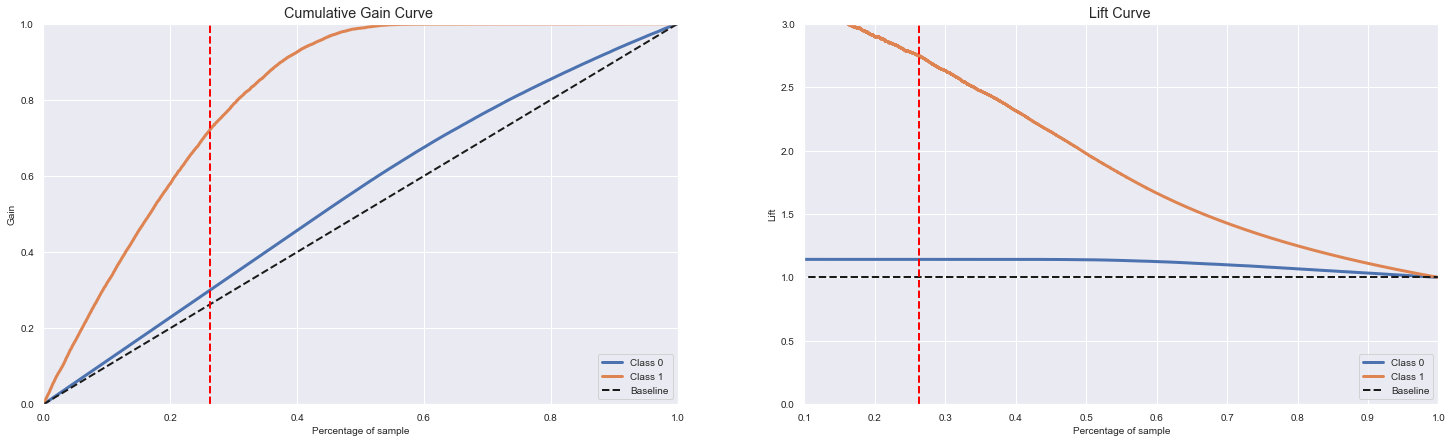

In [216]:
perc_data = 20000 / len(data)
recall_at_20000 = recall_at_k(data, k=20000)
precision_at_20000=precision_at_k(data, k=20000)

print('Percent of data: {:.2%} '.format(perc_data))
print('Recall at K : ',recall_at_20000)
print('Precision at K : ',precision_at_20000)


fig, axs = plt.subplots(ncols=2, figsize=(25,7))
skplt.metrics.plot_cumulative_gain(y_validation, yhat_lgbm_final, ax=axs[0], text_fontsize='small', title='Cumulative Gain Curve ')
axs[0].axvline(perc_data, 0, 1, color='red', ls='--', lw=2);

skplt.metrics.plot_lift_curve(y_validation, yhat_lgbm_final, ax=axs[1], text_fontsize='small', title='Lift Curve ')
axs[1].axvline(perc_data, 0, 1, color='red', ls='--', lw=2);
plt.xlim(0.1,1);
plt.ylim(0,3);



**2 -** Considerando que a equipe de vendas tenha disponibilidade de aumentar o contato para 40.000 clientes, qual a porcentagem de clientes interessados em adquirir seguro de carro ?

**R:** Dentro desse cenário a equipe entraria em contato com 52,48% do total de clientes do nosso conjunto de dados e atingiria 99,41% das pessoas interessadas.

Podemos concluir de acordo com o gráfico "Lift Curve" que com 40.000 contatos nosso modelo é cerca 1,9 vezes melhor que uma escolha aleatória.

Percent of data: 52.48% 
Recall at K :  0.9941195001575134
Precision at K :  0.2366690832729182


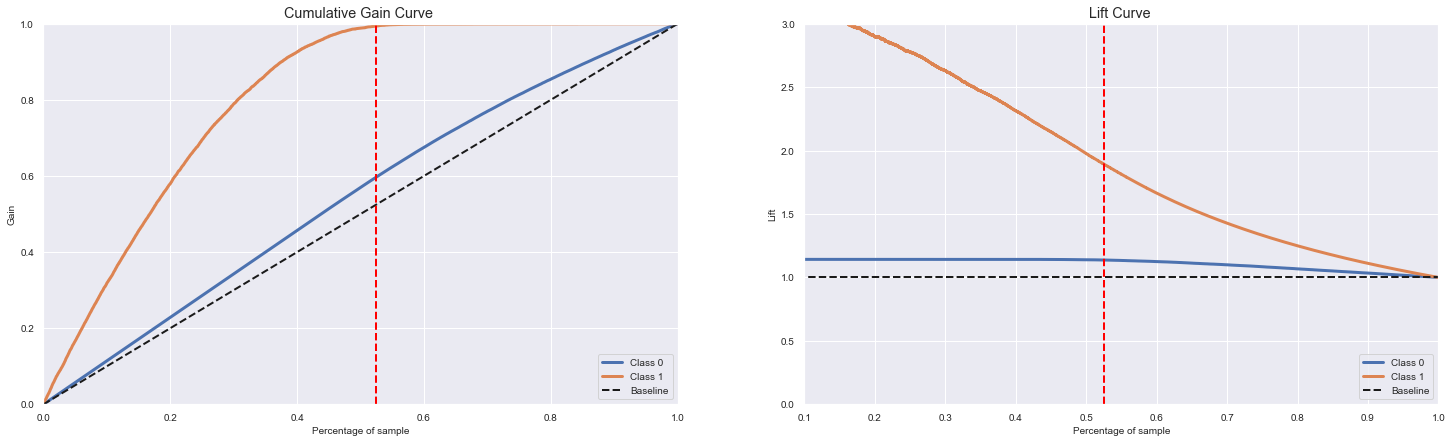

In [217]:
perc_data = 40000 / len(data)
recall_at_40000 = recall_at_k(data, k=40000)
precision_at_40000=precision_at_k(data, k=40000)

print('Percent of data: {:.2%} '.format(perc_data))
print('Recall at K : ',recall_at_40000)
print('Precision at K : ',precision_at_40000)


fig, axs = plt.subplots(ncols=2, figsize=(25,7))
skplt.metrics.plot_cumulative_gain(y_validation, yhat_lgbm_final, ax=axs[0], text_fontsize='small', title='Cumulative Gain Curve ')
axs[0].axvline(perc_data, 0, 1, color='red', ls='--', lw=2);

skplt.metrics.plot_lift_curve(y_validation, yhat_lgbm_final, ax=axs[1], text_fontsize='small', title='Lift Curve ')
axs[1].axvline(perc_data, 0, 1, color='red', ls='--', lw=2);
plt.xlim(0.1,1);
plt.ylim(0,3);


## 9.2 Revenue Business Performance

Considerando 76.222 clientes de nossa base de validação, vamos calcular a receita que seria gerada fixando o preço do seguro em $2.000,00/ano. Utilizaremos como comparação um modelo aleatório que poderia ser qualquer ordenação da lista através de algum atributo específico.


In [218]:
data.shape

(76222, 15)

In [219]:
y_validation.value_counts()

0    66699
1     9523
Name: response, dtype: int64

### 20.000 calls

In [220]:
cost_insurance = 2000

model_random = int(np.round( (26.24 / 100 ) * 9523 ) ) # ( %data ) * len(response= 1)
model_lgbm = int(np.round( (72.12 / 100) * 9523 ) ) # (% recall(20000 calls) * len(response=1 ) )

revenue_random = cost_insurance * model_random 
revenue_model = cost_insurance * model_lgbm


print('Annual Revenue by Random Model: U$ {:,}'.format(revenue_random))
print('Annual Revenue by Model Suggested: U$ {:,}'.format(revenue_model))
print('Difference between models:U$ {:,} ' .format(revenue_model-revenue_random) )

Annual Revenue by Random Model: U$ 4,998,000
Annual Revenue by Model Suggested: U$ 13,736,000
Difference between models:U$ 8,738,000 


### 40.000 calls

In [221]:
cost_insurance = 2000

model_random = int( (52.48 / 100 ) * 9523 ) # ( %data ) * len(response= 1)
model_lgbm = int( (99.41 / 100) * 9523 ) # (% recall(40000 calls) * len(response=1 ) )

revenue_random = cost_insurance * model_random 
revenue_model = cost_insurance * model_lgbm

print('Annual Revenue by Random Model: U$ {:,}'.format(revenue_random))
print('Annual Revenue by Model Suggested: U$ {:,}'.format(revenue_model))
print('Difference between models:U$ {:,} ' .format(revenue_model-revenue_random) )

Annual Revenue by Random Model: U$ 9,994,000
Annual Revenue by Model Suggested: U$ 18,932,000
Difference between models:U$ 8,938,000 


# 10.0 Deploy

In [236]:
# Save trained model
pickle.dump( lgbm_tuned, open( 'C:\\Users\\Codo\\Desktop\\repos\\PA_health_insurance\\src\\models\\model_lgbm.pkl', 'wb' ) )

In [418]:
test = df_test.copy()
test.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage
0,381110,Male,25,1,11.0,1,< 1 Year,No,35786.0,152.0,53
1,381111,Male,40,1,28.0,0,1-2 Year,Yes,33762.0,7.0,111
2,381112,Male,47,1,28.0,0,1-2 Year,Yes,40050.0,124.0,199
3,381113,Male,24,1,27.0,1,< 1 Year,Yes,37356.0,152.0,187
4,381114,Male,27,1,28.0,1,< 1 Year,No,59097.0,152.0,297


In [419]:
cols_test = [col_test.lower() for col_test in test.columns]
test.columns = cols_test

# vehicle_damage
test['vehicle_damage'] = test['vehicle_damage'].apply( lambda x: 1 if x == 'Yes' else 0 )

# vehicle_age
test['vehicle_age'] = test['vehicle_age']. apply( lambda x: 'over_2_years' if x == '> 2 Years' else 'between_1_2_year' if x == '1-2 Year' else 'below_1_year' )

In [420]:
annual_premium_scaler = pickle.load( open( 'C:\\Users\\Codo\\Desktop\\repos\\PA_health_insurance\\src\\features\\annual_premium_scaler.pkl','rb' ) )
age_scaler = pickle.load( open( 'C:\\Users\\Codo\\Desktop\\repos\\PA_health_insurance\\src\\features\\age_scaler.pkl','rb' ) ) 
vintage_scaler = pickle.load( open( 'C:\\Users\\Codo\\Desktop\\repos\\PA_health_insurance\\src\\features\\vintage_scaler.pkl','rb' ) ) 
target_encode_gender_scaler = pickle.load( open( 'C:\\Users\\Codo\\Desktop\\repos\\PA_health_insurance\\src\\features\\target_encode_gender_scaler.pkl','rb'  ) )
target_encode_region_scaler = pickle.load( open( 'C:\\Users\\Codo\\Desktop\\repos\\PA_health_insurance\\src\\features\\target_encode_region_code_scaler.pkl','rb'  ) )
fe_policy_sales_channel_scaler = pickle.load( open( 'C:\\Users\\Codo\\Desktop\\repos\\PA_health_insurance\\src\\features\\fe_policy_sales_channel_scaler.pkl','rb'  ) )


# anual premium - StandarScaler
test['annual_premium'] = annual_premium_scaler.transform( test[['annual_premium']].values )


# Age - MinMaxScaler
test['age'] = age_scaler.transform( test[['age']].values )

# Vintage - Target Encoding
test['vintage'] = age_scaler.transform( test[['vintage']].values )

# gender - One Hot Encoding / Target Encoding
test.loc[:, 'gender'] = test['gender'].map( target_encode_gender_scaler )

# region_code - Target Encoding
test.loc[:, 'region_code'] = test['region_code'].map( target_encode_region_scaler )


# vehicle_age - One Hot Encoding / Frequency Encoding
test = pd.get_dummies( test, prefix='vehicle_age', columns=['vehicle_age'] )

# policy_sales_channel - Target Encoding
test.loc[:, 'policy_sales_channel'] = test['policy_sales_channel'].map( fe_policy_sales_channel_scaler )

test = test.fillna(0)

In [421]:
test.isna().sum()

id                              0
gender                          0
age                             0
driving_license                 0
region_code                     0
previously_insured              0
vehicle_damage                  0
annual_premium                  0
policy_sales_channel            0
vintage                         0
vehicle_age_below_1_year        0
vehicle_age_between_1_2_year    0
vehicle_age_over_2_years        0
dtype: int64

In [422]:
cols_selected = ['annual_premium', 'vintage', 'age', 'region_code', 'vehicle_damage', 'previously_insured', 'policy_sales_channel']

test = test[ cols_selected ]

In [423]:
model_lgbm = pickle.load( open( 'C:\\Users\\Codo\\Desktop\\repos\\PA_health_insurance\\src\\models\\model_lgbm.pkl', 'rb' ) )
yhat_lgbm_proba = model_lgbm.predict_proba( test )


In [424]:
df_test['Score'] = yhat_lgbm_proba[:, 1]
df_test = df_test.sort_values('Score', ascending=False)
df_test = df_test.reset_index(drop=True)
df_test['Ranking'] = df_test.index + 1
df_test.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Score,Ranking
0,476782,Female,32,1,30.0,0,1-2 Year,Yes,27342.0,163.0,255,0.595664,1
1,469061,Male,29,1,30.0,0,1-2 Year,Yes,27069.0,163.0,191,0.594414,2
2,387873,Female,31,1,10.0,0,1-2 Year,Yes,29340.0,163.0,19,0.578083,3
3,446265,Male,35,1,30.0,0,1-2 Year,Yes,29117.0,124.0,219,0.578020,4
4,382880,Male,33,1,30.0,0,< 1 Year,Yes,23753.0,163.0,179,0.576734,5


##  9.1 Health Insurance Class

In [ ]:
import pickle
import numpy as np
import pandas as pd

class HealthInsurance:
    
    def __init__( self ):
        self.home_path = 'C:\\Users\\Codo\\Desktop\\repos\\PA_health_insurance'
        self.annual_premium_scaler = pickle.load(open( self.home_path + 'src\\features\\annual_premium_scaler.pkl') )
        self.age_scaler = pickle.load(open( self.home_path + 'src\\features\\age_scaler.pkl') )
        self.vintage_scaler = pickle.load(open( self.home_path + 'src\\features\\vintage_scaler.pkl') )
        self.target_encode_gender_scaler = pickle.load( open( self.home_path + 'src\\features\\target_encode_gender_scaler.pkl') )
        self.target_encode_region_code_scaler = pickle.load( open( self.home_path + 'src\\features\\target_encode_region_code_scaler.pkl') )
        self.fe_policy_sales_channel_scaler = pickle.load( open( self.home_path + 'src\\features\\fe_policy_sales_channel_scaler.pkl') ) 

    def data_cleaning( self, df1 ):
        # 1.1 Rename Columns
        cols_new = ['id', 'gender', 'age', 'driving_license', 'region_code', 'previously_insured', 'vehicle_age', 
                    'vehicle_damage', 'annual_premium', 'policy_sales_channel', 'vintage']

        # rename 
        df1.columns = cols_new
                
        return df1 

    def feature_engineering( self, df2 ):

        # vehicle_damage
        df2['vehicle_damage'] = df2['vehicle_damage'].apply( lambda x: 1 if x == 'Yes' else 0 )

        # vehicle_age
        df2['vehicle_age'] = df2['vehicle_age']. apply( lambda x: 'over_2_years' if x == '> 2 Years' else 'between_1_2_year' if x == '1-2 Year' else 'below_1_year' )
            

        return df2
        
    def data_preparation ( self, df5):

        # annual_premium
        df5['annual_premium'] = self.annual_premium_scaler.transform( df5[['annual_premium']].values )

        # age - MinMaxScaler
        df5['age'] = self.age_scaler.transform( df5[['age']].values )
       
        # vintage - MinMaxScaler
        df5['vintage'] = self.vintage_scaler.transform( df5[['vintage']].values )
        
        # gender - One Hot Encoding / Target Enconding
        df5.loc[:, 'gender'] = df5['gender'].map( self.target_encode_gender_scaler )
        
        # region_code -  Frequency Enconding / Target Enconding
        df5.loc[:, 'region_code'] = df5['region_code'].map( self.target_encode_gender_scaler )
        
        # vehicle_age - One Hot Enconding / Frequency Enconding 
        df5 = pd.get_dummies( df5, prefix='vehicle_age', columns=['vehicle_age'] )

        # policy_sales_channel - Frequency Encoding
        df5.loc[:, 'policy_sales_channel'] = df5['policy_sales_channel'].map( self.fe_policy_sales_channel_scaler )

        # Feature Selection
        cols_selected = ['annual_premium', 'vintage', 'age', 'region_code', 'vehicle_damage', 'previously_insured',
                         'policy_sales_channel']

        return df5[ cols_selected ]

    def get_prediction( self, model, original_data, test_data ):
        # model prediction
        pred = model.predict_proba( test_data )
        
        # join prediction into original data
        original_data['prediction'] = pred
        
        return original_data.to_json( orient='records', date_format='iso' )



## 9.2 API Handler

In [ ]:
import pickle
import pandas as pd
from flask import Flask, request, Response
from healthinsurance.HealthInsurance import HealthInsurance

# loading model
path = 'C:\\Users\\Codo\\Desktop\\repos\\PA_health_insurance'
model = pickle.load( open( path + '\\src\\models\\model_linear_regression.pkl', 'rb' ) )

# initialize API
app = Flask( __name__ )

@app.route( '/heathinsurance/predict', methods=['POST'] )
def healthinsurance_predict():
    test_json = request.get_json()
    
    if test_json: # there is data
        if isinstance( test_json, dict ): # unique example
            test_raw = pd.DataFrame( test_json, index=[0] )
            
        else: # multiple example
            test_raw = pd.DataFrame( test_json, columns=test_json[0].keys() )
            
        # Instantiate Rossmann class
        pipeline = HealthInsurance()
        
        # data cleaning
        df1 = pipeline.data_cleaning( test_raw )
        
        # feature engineering
        df2 = pipeline.feature_engineering( df1 )
        
        # data preparation
        df3 = pipeline.data_preparation( df2 )
        
        # prediction
        df_response = pipeline.get_prediction( model, test_raw, df3 )
        
        return df_response
    
    else:
        return Response( '{}', status=200, mimetype='application/json' )
    
if __name__ == '__main__':
    app.run( '0.0.0.0' )

## 9.3 API Tester

In [ ]:
import requests
import json
import math

In [ ]:
df_test = x_validation.drop( 'response', axis=1 )

In [ ]:
df_test = pd.read_csv('C:\\Users\\Codo\Desktop\\repos\\PA_health_insurance\\data\\test.csv')


In [ ]:
df_test.info()

In [ ]:
cols_old = ['id', 'Gender', 'Age', 'Driving_License', 'Region_Code',
            'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage', 'Annual_Premium',
            'Policy_Sales_Channel', 'Vintage']

# Rename columns
snakecase = lambda x: inflection.underscore(x)
cols_new = list(map(snakecase, cols_old))
df_test.columns = cols_new

In [ ]:
df_test.head()

In [ ]:
# vehicle_damage
df_test['vehicle_damage'] = df_test['vehicle_damage'].apply( lambda x: 1 if x == 'Yes' else 0 )

# vehicle_age
df_test['vehicle_age'] = df_test['vehicle_age']. apply( lambda x: 'over_2_years' if x == '> 2 Years' else 'between_1_2_year' if x == '1-2 Year' else 'below_1_year' )

In [ ]:
x_validation.head()

In [ ]:
# convert dataframe to json
data = json.dumps( df_test.to_dict( orient='records' ) )

In [ ]:
df_test.head()

In [ ]:
# API Call
#url = 'http://192.168.0.202:5000/predict'
url = 'https://p03-health-insurance-crosssell.herokuapp.com/predict'
#url = 'https://health-insurance-model.herokuapp.com/predict'
header = {'Content-type': 'application/json' }

r = requests.post( url, data=data, headers=header )
print( 'Status Code {}'.format( r.status_code ) )

In [ ]:
d1 = pd.DataFrame( r.json(), columns=r.json()[0].keys() )
d1.sort_values( 'score', ascending=False ).head()